# Análise de Redes de personagens em STAR WARS: THE CLONE WARS
<img src="../images/tcw.jpg" width="800" style="border-radius: 8px;">

## 1. Introdução
The Clone Wars apresenta uma narrativa complexa, com múltiplos núcleos e centenas de personagens. O objetivo desta análise é investigar interações entre personagens, identificar centrais e padrões narrativos.

## 2. Metodologia e Técnicas Utilizadas

### 2.1 Processamento de Linguagem Natural (NLP)
- **spaCy com modelo `en_core_web_trf`**  
- **Extração e normalização de nomes de personagens**

### 2.2 Análise de Redes Complexas
- **Co-ocorrência de personagens**

### 2.3 Análise Temporal
- **Séries temporais por temporada**
- **Comparação sazonal**  
- **Grafos dinâmicos por temporada**.  

## Importando as bilbliotecas

In [1]:
import os
import sys

import spacy
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
from IPython.display import IFrame

sys.path.append(os.path.abspath(".."))

from src.data_processing import (
    load_and_process_subtitles,
    get_ners,
    normalize_names
)

from src.network_analysis import (
    generate_relationships_by_season,
    assign_group,
    create_season_network,
    analyze_seasons_comparison,
    get_relationship_data
)

from src.visualization import (
    plot_relationships_comparison
)

plt.style.use('bmh')

## 3. Construção do dataset

### 3.1 Coletando arquivos de legenda

In [2]:
subtitles_path = sorted(glob("../data/subs/*.srt"))

In [3]:
subtitles_path[:5]

['../data/subs\\The Clone Wars Season 1 - 01.srt',
 '../data/subs\\The Clone Wars Season 1 - 02.srt',
 '../data/subs\\The Clone Wars Season 1 - 03.srt',
 '../data/subs\\The Clone Wars Season 1 - 04.srt',
 '../data/subs\\The Clone Wars Season 1 - 05.srt']

### 3.2 Processando legendas e criando o DataFrame

In [4]:
df = load_and_process_subtitles(subtitles_path)
df = df.sort_values(['season', 'episode']).reset_index(drop=True)
df.head()

,season,episode,script
0,1,1,A galaxy divided by war. Peaceful worlds must ...
1,1,2,The clone Starfleet is under siege. Dozens of ...
2,1,3,A deadly weapon unleashed. The Separatist batt...
3,1,4,Grievous in retreat! Before the battleship Mal...
4,1,5,Clone forces rally. As the war escalates in th...


### 3.3 Estatísticas do Dataset

In [5]:
print(f"Total de episódios: {len(df)}")
print(f"Temporadas: {df['season'].unique()}")
print(f"Episódios por temporada:")
print(df['season'].value_counts().sort_index())

Total de episódios: 133
Temporadas: [1 2 3 4 5 6 7]
Episódios por temporada:
season
1    22
2    22
3    22
4    22
5    20
6    13
7    12
Name: count, dtype: int64


### 3.4 Exemplo de Script

In [6]:
df.iloc[0]['script']

'A galaxy divided by war. Peaceful worlds must choose sides or face the threat of invasion. Republic and Separatist armies vie for the allegiance of neutral planets. Desperate to build a Republic supply base in the system of Toydaria, Jedi Master Yoda travels to secret negotiations on a remote neutral moon. We are getting no signal from the Republic, Your Highness. I don\'t see anything. It is not like the Jedi to be late. Greetings, King Katuunko. - Who are you? - I am only a messenger, Majesty. My master wishes to speak with you. Katuunko, great king of Toydaria, forgive my intrusion. Count Dooku. I am aware Master Yoda hopes you will allow the Jedi to build a Republic base in your system in exchange for protection, correct? Your spies serve you well, Count. I ask, how can the Jedi protect you if they cannot protect themselves? Toydarian Royal Delegation, this is the Republic Envoy. Please respond. General, the Toydarians\' beacon is active on the moon, but all our transmissions are 

### 3.5 Configuração e teste do Modelo spaCy

In [7]:
nlp = spacy.load("en_core_web_trf")

In [8]:
doc = nlp("Luke flew to Dagobah")

In [9]:
for ent in doc.ents: 
    print(ent.text,ent.label_)

Luke PERSON
Dagobah GPE


## 4. Redes por temporada

### 4.1 Extração de Entidades Nomeadas (NER)

In [11]:
tqdm.pandas()
df['ners'] = df['script'].progress_apply(lambda x: get_ners(x, nlp))

100%|████████████████████████████████████████████████████████████████████████████████| 133/133 [21:20<00:00,  9.63s/it]


### 4.2 Normalizando os nomes

In [12]:
df['ners_normalized'] = df['ners'].apply(normalize_names)

### 4.3 Criando um dataframe de relacionamento

In [13]:
relationships_by_season = generate_relationships_by_season(df)

In [14]:
relationships_by_season[1].head()

,source,target,value
66,Anakin,Obi-Wan,65
8,Ahsoka,Anakin,46
52,Anakin,Grievous,38
49,Anakin,Dooku,30
73,Anakin,Rex,28


### 4.4 Criando redes de personagens por temporada

In [15]:
season_networks = {}

print("Redes por temporada:")
print("=" * 51)

for season in sorted(relationships_by_season.keys()):
    rel_df = relationships_by_season[season]
    if not rel_df.empty:
        G_season = create_season_network(rel_df, season, min_occurrences=3)
        if G_season:
            season_networks[season] = G_season
    else:
        print(f"Temporada {season}: DataFrame vazio")

Redes por temporada:
network_season_1.html
Temporada 1:
45 personagens, 99 relações
Relação principal: Anakin - Obi-Wan (65 interações)
Salvo como: network_season_1.html

network_season_2.html
Temporada 2:
61 personagens, 123 relações
Relação principal: Anakin - Obi-Wan (69 interações)
Salvo como: network_season_2.html

network_season_3.html
Temporada 3:
59 personagens, 104 relações
Relação principal: Ahsoka - Anakin (44 interações)
Salvo como: network_season_3.html

network_season_4.html
Temporada 4:
59 personagens, 122 relações
Relação principal: Anakin - Obi-Wan (43 interações)
Salvo como: network_season_4.html

network_season_5.html
Temporada 5:
40 personagens, 71 relações
Relação principal: Ahsoka - Anakin (47 interações)
Salvo como: network_season_5.html

network_season_6.html
Temporada 6:
30 personagens, 49 relações
Relação principal: Anakin - Clovis (45 interações)
Salvo como: network_season_6.html

network_season_7.html
Temporada 7:
31 personagens, 58 relações
Relação principa

In [16]:
display(IFrame(src='network_season_2.html', width=1600, height=900))

## 5. Análise comparativa entre temporadas

### 5.1. Comparação longitudinal

In [17]:
season_comparison = analyze_seasons_comparison(season_networks)

Análise comparativa entre temporadas:
- Temporada 1:
     Personagens: 45
     Relações: 99
     Grau médio: 4.40
     Personagem central: Anakin

- Temporada 2:
     Personagens: 61
     Relações: 123
     Grau médio: 4.03
     Personagem central: Anakin

- Temporada 3:
     Personagens: 59
     Relações: 104
     Grau médio: 3.53
     Personagem central: Anakin

- Temporada 4:
     Personagens: 59
     Relações: 122
     Grau médio: 4.14
     Personagem central: Anakin

- Temporada 5:
     Personagens: 40
     Relações: 71
     Grau médio: 3.55
     Personagem central: Ahsoka

- Temporada 6:
     Personagens: 30
     Relações: 49
     Grau médio: 3.27
     Personagem central: Dooku

- Temporada 7:
     Personagens: 31
     Relações: 58
     Grau médio: 3.74
     Personagem central: Rex



## 6. Relações do trio de protagonistas durante a série

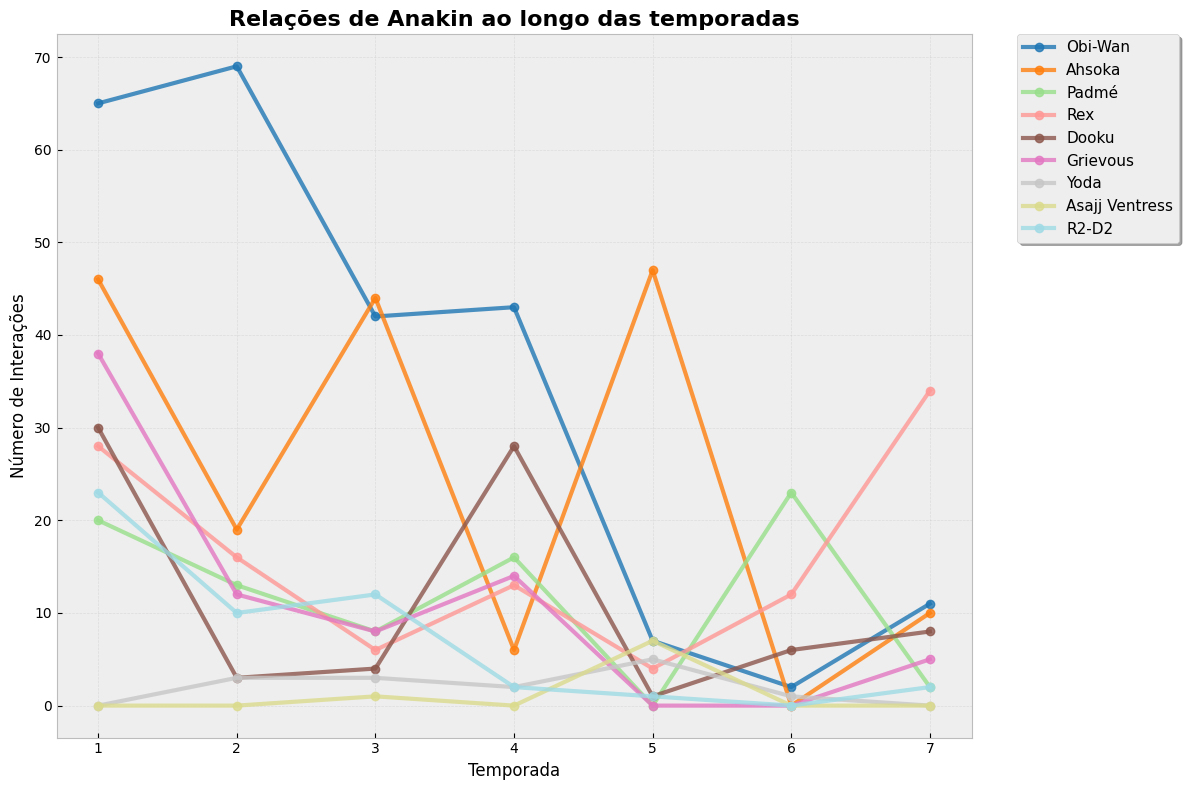

In [18]:
characters_to_compare = ['Obi-Wan', 'Ahsoka', 'Padmé', 'Rex', 'Dooku', 'Grievous', 'Yoda' ,'Asajj Ventress', 'R2-D2']
plot_relationships_comparison(relationships_by_season, 'Anakin', characters_to_compare)

In [19]:
characters_to_compare = ['Anakin', 'Obi-Wan', 'Padmé', 'Rex', 'Dooku', 'Grievous', 'Asajj Ventress', 'Barriss Offee']

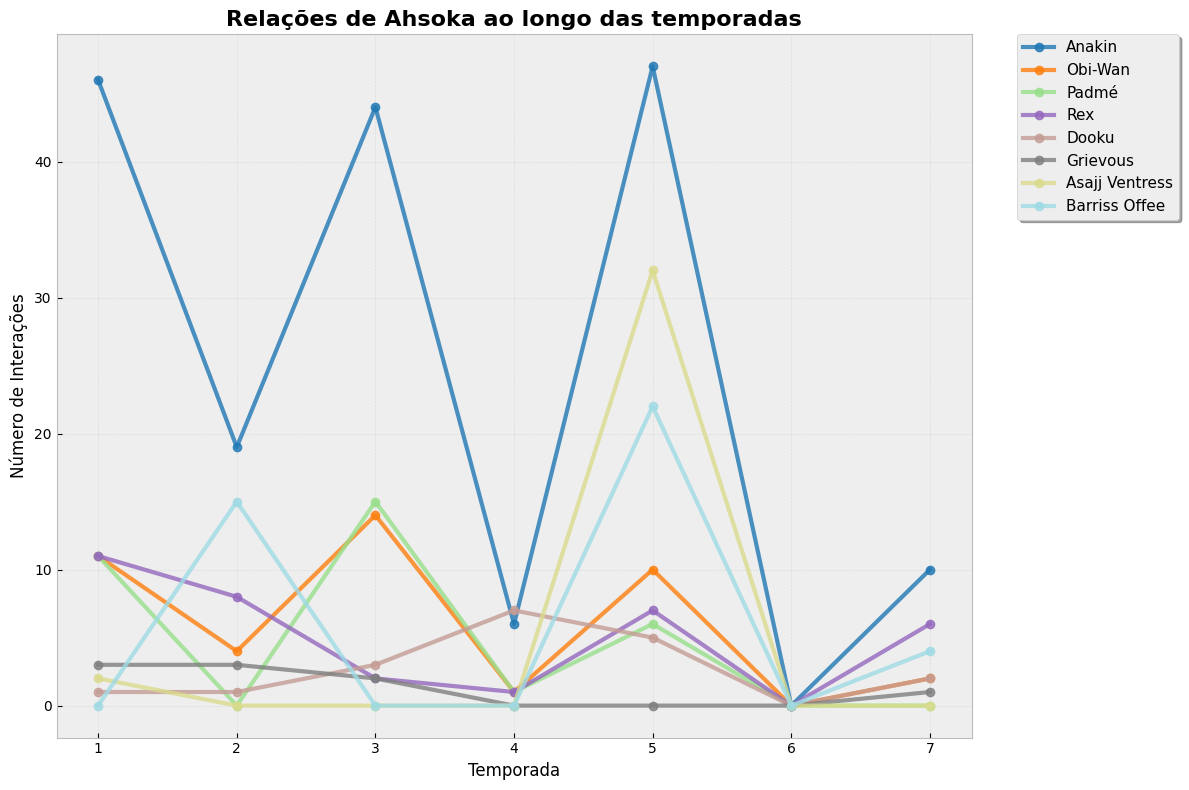

In [20]:
plot_relationships_comparison(relationships_by_season, 'Ahsoka', characters_to_compare)

In [21]:
characters_to_compare = ['Ahsoka', 'Anakin', 'Rex', 'Cody', 'Dooku', 'Grievous', 'Satine', 'Darth Maul', 'Savage Opress', 'Yoda', 'R2-D2']

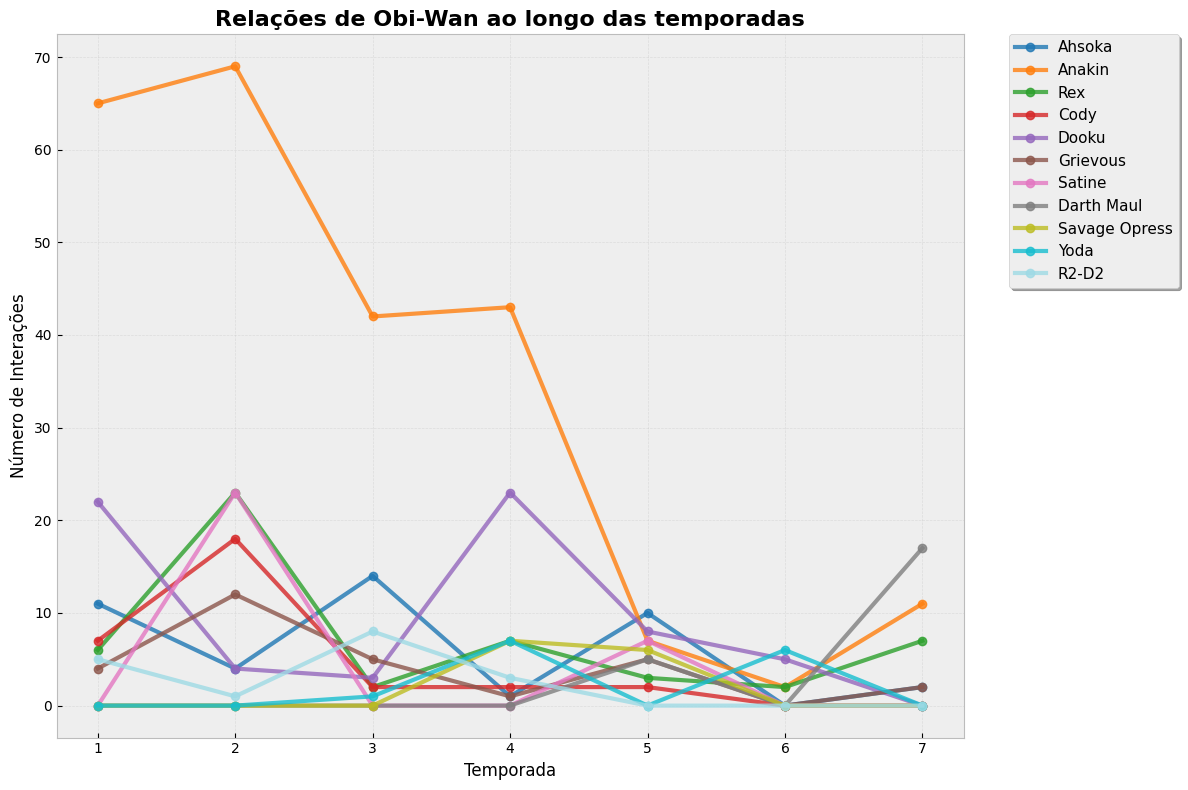

In [22]:
plot_relationships_comparison(relationships_by_season, 'Obi-Wan', characters_to_compare)